## The symmetric 4-city problem

solving the bottleneck travelling salesman problem using phase estimation.

### testing contraint:

 - 6 qubits for phase estimation.
 - 8 qubits initialized to the eigenvalue of the of the matrix $U$.
 - There are 3 hamilonian cycles, so we need eigenvalue and estimation qubits for each.
 - To solve the constraint problem we need a new operator $U$ satifying a max edge weight.

<div>
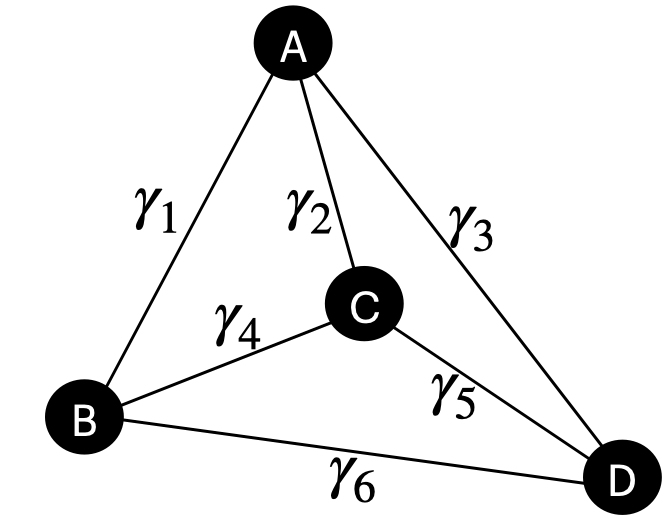
</div>

### we can assign arbitrary weights

$$\Large A\xrightarrow{\gamma_1}B \xrightarrow{\gamma_4}C \xrightarrow{\gamma_5}D\xrightarrow{\gamma_3}A: 4 + 4 + \mathbf{5} + 4 = 17$$

$$\Large A\xrightarrow{\gamma_1}B \xrightarrow{\gamma_6}D \xrightarrow{\gamma_5}C\xrightarrow{\gamma_2}A: 4 + \mathbf{6} + 5 + 2 = 17$$

$$\Large A\xrightarrow{\gamma_2}C \xrightarrow{\gamma_4}B \xrightarrow{\gamma_6}D\xrightarrow{\gamma_3}A: 2 + 4 + \mathbf{6} + 4 = 16$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

gamma_1 = 4 # a <-> b
gamma_2 = 2 # a <-> c
gamma_3 = 4 # a <-> d
gamma_4 = 4 # b <-> c
gamma_5 = 5 # c <-> d
gamma_6 = 6 # b <-> d

weights = []

for i in range(1, 7):
    variable_name = "gamma_" + str(i)
    # Assuming you have variables like number_1, number_2, etc.
    current_number = locals()[variable_name]
    weights.append(current_number)

weights = np.array(weights)
print(weights)


[4 2 4 4 5 6]


we need to normalize the weights, $w$, so we only have values in $(0, 2\pi)$. We can do this by:

$$\Large w = \frac{w}{\mathrm{max}(w) + \epsilon} \times 2\pi$$

The addition of $\epsilon$ is included to avoid a max normalized weight of $2\pi$

In [2]:
eps = 1
weights = weights / (max(weights) + eps) * 2 * np.pi
print(weights)


[3.5903916  1.7951958  3.5903916  3.5903916  4.48798951 5.38558741]


To construct $U$, we need to compute the tensor product of diagonal matrices $U_j$, where $ 1 \leq j \leq N$. $N$ denotes the number of cities in total.

$$\Large\left[U_j \right]_{kk} = \frac{1}{\sqrt{N}}e^{i\gamma_{jk}}$$


$$\Large U = \bigotimes_j^N U_j$$


for our contstraint test, we simply need a tensor product of 4 matrices:

$$\Large U = U_1 \otimes U_2 \otimes U_3 \otimes U_4$$

lets have a closer look at the matrix $U_1$
$$ \Large
\begin{bmatrix}
  1 & 0 & 0 & 0 \\
  0 & e^{i\gamma_{12}} & 0 & 0 \\
  0 & 0 & e^{i\gamma_{13}} & 0 \\
  0 & 0 & 0 & e^{i\gamma_{14}} \\
\end{bmatrix}
$$

constructing the large matrix U is straight forward. I am a little confused on how to construct a controlled-U operation such that we have the appropriate phase kickback. The 2018 paper does a decomposition, and claims that a $CU$ matrix can simply be achieved by the tensor product of the smaller $CU_J$ matrices. Need to confirm how this works.

A control gate can simply be constructed:

$$ \Large
\begin{bmatrix}
  \mathbb{1} & 0 \\
  0 & U \\
\end{bmatrix}
$$ 


#### January 16th clarification:

to construct a control gate, we need an equal amount of diagonal elements for the identity matrix above as we have in the diagonal of U, implying we double the size of U and store 1s in the first half of the diagonal 

In [3]:
# https://github.com/qiskit-community/qiskit-textbook/blob/main/content/ch-algorithms/quantum-phase-estimation.ipynb
# https://www.youtube.com/watch?v=zFgyMGklANM (how to create a custom gate)  

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT

# for creating custom gates
from qiskit import quantum_info as qi

# import basic plot tools
from qiskit.visualization import plot_histogram

In [4]:
## create and set up quantum circuits

# initialization

n = 3 # estimation qubits
m = 8 # eigenvalue qubits

qpe = QuantumCircuit(n + m, n)

# Apply H-Gates to counting qubits:
for qubit in range(n):
    qpe.h(qubit)

# Prepare our eigenstate |psi>:
eig = '11000110'

for ind, val in enumerate(eig):
    if(int(val)):
        qpe.x(ind + n)
    
qpe.draw()

┌───┐
 q_0: ┤ H ├
      ├───┤
 q_1: ┤ H ├
      ├───┤
 q_2: ┤ H ├
      ├───┤
 q_3: ┤ X ├
      ├───┤
 q_4: ┤ X ├
      └───┘
 q_5: ─────
           
 q_6: ─────
           
 q_7: ─────
      ┌───┐
 q_8: ┤ X ├
      ├───┤
 q_9: ┤ X ├
      └───┘
q_10: ─────
           
 c: 3/═════

In [5]:
# creating our CU matrix (example just as the identity to draw the rest of the circuit)
CU = qi.Operator(np.diag(np.ones(2**(m+1))))
CU


Operator([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2))

## recreating CU matrix

In [6]:
### need the four values for each sub distance matrix:

U111 = 1
U122 = np.exp(1j * weights[0])
U133 = np.exp(1j * weights[1])
U144 = np.exp(1j * weights[2])
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0])
U222 = 1
U233 = np.exp(1j * weights[3])
U244 = np.exp(1j * weights[4])
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1])
U322 = np.exp(1j * weights[3])
U333 = 1
U344 = np.exp(1j * weights[4])
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2])
U422 = np.exp(1j * weights[5])
U433 = np.exp(1j * weights[4])
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

## tensor product all of them
## Add ones to the diagonal (first half)

U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(U != 0)# confirming only the diagonal is being used.

CUdiag = np.append(np.ones(2**m), np.diag(U))

CU = qi.Operator(np.diag(CUdiag))
print(np.shape(CU))  ### needs to work on m + 1 qubits (2^(m+1) x 2^(m+1) matrix)


[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
(512, 512)


## Creating CU Prime matrix (removing max edge weight)

In [7]:
### need the four values for each sub distance matrix:

max_index = np.where(weights == np.max(weights))[0][0] ## largest weight in weights index
weights[max_index] = 0                                 ## setting the largest weight to zero

U111 = 1
U122 = np.exp(1j * weights[0])
U133 = np.exp(1j * weights[1])
U144 = np.exp(1j * weights[2])
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0])
U222 = 1
U233 = np.exp(1j * weights[3])
U244 = np.exp(1j * weights[4])
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1])
U322 = np.exp(1j * weights[3])
U333 = 1
U344 = np.exp(1j * weights[4])
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2])
U422 = np.exp(1j * weights[5])
U433 = np.exp(1j * weights[4])
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

## tensor product all of them
## Add ones to the diagonal (first half)

U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(U != 0)# confirming only the diagonal is being used.

CUdiag = np.append(np.ones(2**m), np.diag(U))

CUP = qi.Operator(np.diag(CUdiag))
print(np.shape(CUP))  ### needs to work on m + 1 qubits (2^(m+1) x 2^(m+1) matrix)

[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
(512, 512)


In [8]:
eig_qubits = np.arange(0,m) + n

repetitions = 1
for counting_qubit in range(n):
    applied_qubits = np.append([counting_qubit], [eig_qubits])
    for i in range(repetitions):
        qpe.unitary(CU, list(applied_qubits), label = "CU"); # This is CU
    repetitions *= 2
    
np.array
qpe.draw()



┌───┐┌─────┐                                          
 q_0: ┤ H ├┤0    ├──────────────────────────────────────────
      ├───┤│     │┌─────┐┌─────┐                            
 q_1: ┤ H ├┤     ├┤0    ├┤0    ├────────────────────────────
      ├───┤│     ││     ││     │┌─────┐┌─────┐┌─────┐┌─────┐
 q_2: ┤ H ├┤     ├┤     ├┤     ├┤0    ├┤0    ├┤0    ├┤0    ├
      ├───┤│     ││     ││     ││     ││     ││     ││     │
 q_3: ┤ X ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├
      ├───┤│     ││     ││     ││     ││     ││     ││     │
 q_4: ┤ X ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├
      └───┘│     ││     ││     ││     ││     ││     ││     │
 q_5: ─────┤3 CU ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├
           │     ││  CU ││  CU ││     ││     ││     ││     │
 q_6: ─────┤4    ├┤4    ├┤4    ├┤4 CU ├┤4 CU ├┤4 CU ├┤4 CU ├
           │     ││     ││     ││     ││     ││     ││     │
 q_7: ─────┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├
      ┌───┐│     ││     ││     ││     ││     ││     ││     │
 q_8: ┤ X ├┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├
      ├───┤│     ││     ││     ││     ││     ││     ││     │
 q_9: ┤ X ├┤7    ├┤7    ├┤7    ├┤7    ├┤7    ├┤7    ├┤7    ├
      └───┘│     ││     ││     ││     ││     ││     ││     │
q_10: ─────┤8    ├┤8    ├┤8    ├┤8    ├┤8    ├┤8    ├┤8    ├
           └─────┘└─────┘└─────┘└─────┘└─────┘└─────┘└─────┘
 c: 3/══════════════════════════════════════════════════════

In [9]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

        
# def qft_dagger(qc, n, k):
#     """n-qubit QFTdagger the first n qubits in circ
#         rewriting to account for a bit shift
#     """
#     # Don't forget the Swaps!
#     for qubit in range(n//2):
#         qc.swap(k + qubit, k + n-qubit-1)
#     for j in range(n):
#         for m in range(j):
#             qc.cp(-math.pi/float(2**(j-m)), m, j)
#         qc.h(j)
        

qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, n)
# Measure
qpe.barrier()
for i in range(n):
    qpe.measure(i,i) 
    
qpe.draw()

┌───┐┌─────┐                                           ░    ┌───┐»
 q_0: ┤ H ├┤0    ├───────────────────────────────────────────░──X─┤ H ├»
      ├───┤│     │┌─────┐┌─────┐                             ░  │ └───┘»
 q_1: ┤ H ├┤     ├┤0    ├┤0    ├─────────────────────────────░──┼──────»
      ├───┤│     ││     ││     │┌─────┐┌─────┐┌─────┐┌─────┐ ░  │      »
 q_2: ┤ H ├┤     ├┤     ├┤     ├┤0    ├┤0    ├┤0    ├┤0    ├─░──X──────»
      ├───┤│     ││     ││     ││     ││     ││     ││     │ ░         »
 q_3: ┤ X ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├─░─────────»
      ├───┤│     ││     ││     ││     ││     ││     ││     │ ░         »
 q_4: ┤ X ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├─░─────────»
      └───┘│     ││     ││     ││     ││     ││     ││     │ ░         »
 q_5: ─────┤3 CU ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├─░─────────»
           │     ││  CU ││  CU ││     ││     ││     ││     │ ░         »
 q_6: ─────┤4    ├┤4    ├┤4    ├┤4 CU ├┤4 CU ├┤4 CU ├┤4 CU ├─░─────────»
           │     ││     ││     ││     ││     ││     ││     │ ░         »
 q_7: ─────┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├─░─────────»
      ┌───┐│     ││     ││     ││     ││     ││     ││     │ ░         »
 q_8: ┤ X ├┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├─░─────────»
      ├───┤│     ││     ││     ││     ││     ││     ││     │ ░         »
 q_9: ┤ X ├┤7    ├┤7    ├┤7    ├┤7    ├┤7    ├┤7    ├┤7    ├─░─────────»
      └───┘│     ││     ││     ││     ││     ││     ││     │ ░         »
q_10: ─────┤8    ├┤8    ├┤8    ├┤8    ├┤8    ├┤8    ├┤8    ├─░─────────»
           └─────┘└─────┘└─────┘└─────┘└─────┘└─────┘└─────┘ ░         »
 c: 3/═════════════════════════════════════════════════════════════════»
                                                                       »
«                                               ░ ┌─┐      
« q_0: ─■──────────────■────────────────────────░─┤M├──────
«       │P(-π/2) ┌───┐ │                        ░ └╥┘┌─┐   
« q_1: ─■────────┤ H ├─┼─────────■──────────────░──╫─┤M├───
«                └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║ └╥┘┌─┐
« q_2: ────────────────■─────────■────────┤ H ├─░──╫──╫─┤M├
«                                         └───┘ ░  ║  ║ └╥┘
« q_3: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_4: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_5: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_6: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_7: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_8: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_9: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
«q_10: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« c: 3/════════════════════════════════════════════╩══╩══╩═
«                                                  0  1  2

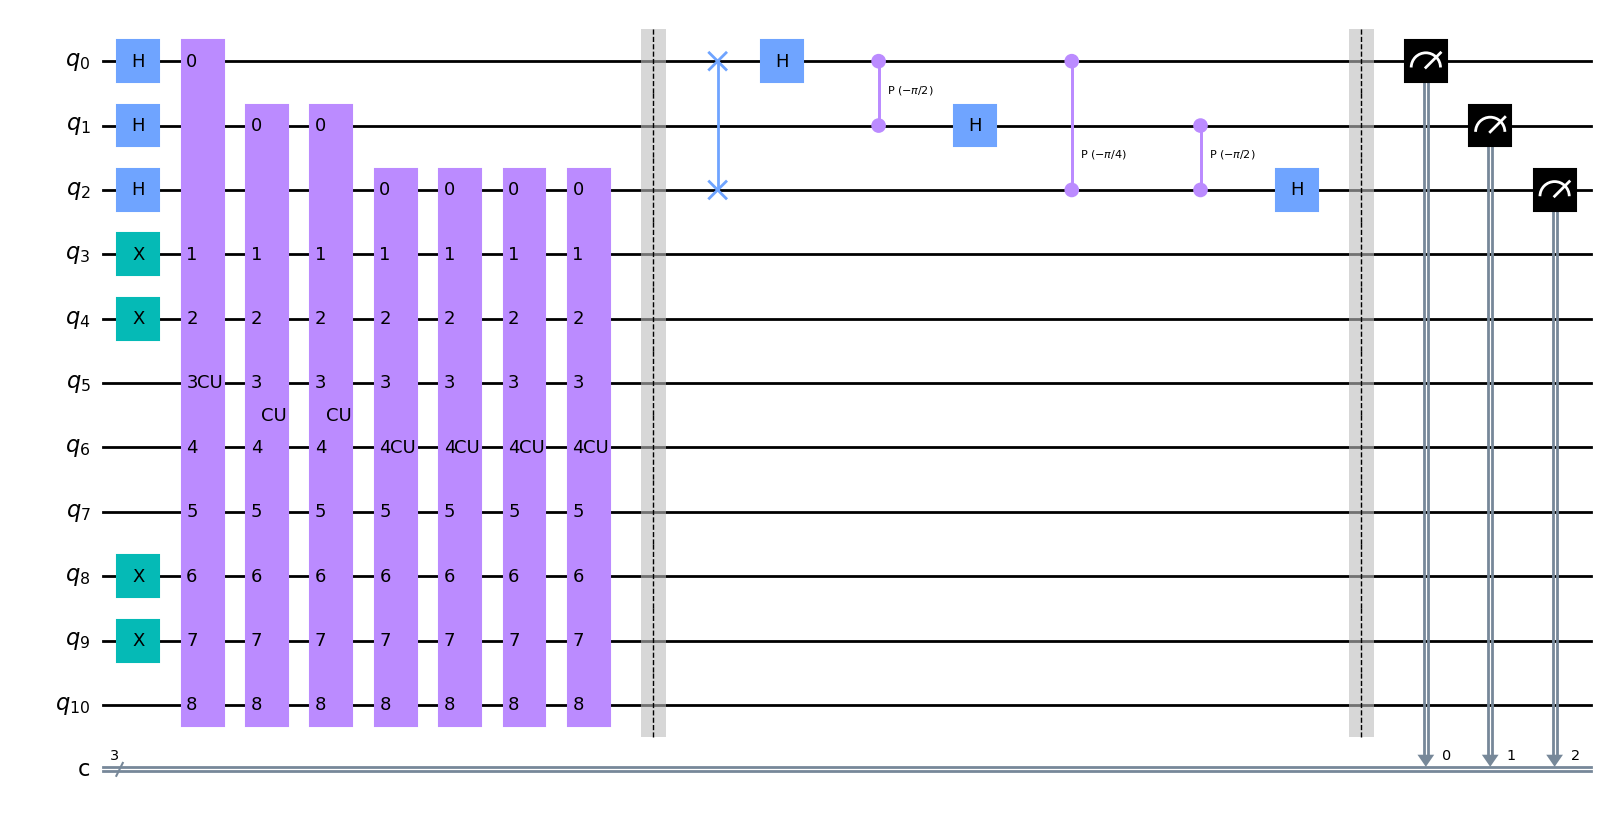

In [10]:
qpe.draw(output = 'mpl')

In [11]:
#qpe.draw(output = 'latex') did not work


In [12]:
qr = QuantumRegister(n, name = 'phase')
qr2 = QuantumRegister(m, name = 'eigenstate')
cr = ClassicalRegister(n, 'output')

qrp = QuantumRegister(n, name = 'phase two')
qr2p = QuantumRegister(m, name = 'eigstate two')
crp = ClassicalRegister(n, 'output two')

qc = QuantumCircuit(qr,qr2,cr,qrp,qr2p,crp)


# Apply H-Gates to counting qubits:
for qubit in range(2*n):
    if qubit < n:
        qc.h(qubit)
    else:
        qc.h(qubit + m)

# Prepare our eigenstate |psi>:
eig = '11000110'

eigstatelist = ['11000110', '01101100', '10001101',
                '01110010', '11100001', '10110100']

for ind, val in enumerate(eig):
    if(int(val)):
        qc.x(ind + n)
        qc.x(ind + 2*n + m)

qc.draw()



┌───┐
       phase_0: ┤ H ├
                ├───┤
       phase_1: ┤ H ├
                ├───┤
       phase_2: ┤ H ├
                ├───┤
  eigenstate_0: ┤ X ├
                ├───┤
  eigenstate_1: ┤ X ├
                └───┘
  eigenstate_2: ─────
                     
  eigenstate_3: ─────
                     
  eigenstate_4: ─────
                ┌───┐
  eigenstate_5: ┤ X ├
                ├───┤
  eigenstate_6: ┤ X ├
                └───┘
  eigenstate_7: ─────
                ┌───┐
   phase two_0: ┤ H ├
                ├───┤
   phase two_1: ┤ H ├
                ├───┤
   phase two_2: ┤ H ├
                ├───┤
eigstate two_0: ┤ X ├
                ├───┤
eigstate two_1: ┤ X ├
                └───┘
eigstate two_2: ─────
                     
eigstate two_3: ─────
                     
eigstate two_4: ─────
                ┌───┐
eigstate two_5: ┤ X ├
                ├───┤
eigstate two_6: ┤ X ├
                └───┘
eigstate two_7: ─────
                     
      output: 3/═════
                     
  output two: 3/═════

In [14]:
eig_qubits = np.arange(0,m) + n
eig_qubits2 = np.arange(0,m) + 2*n + m

repetitions = 1
for counting_qubit in range(n):
    applied_qubits = np.append([counting_qubit], [eig_qubits])
    applied_qubits2 = np.append([counting_qubit + m + n], [eig_qubits2])
    for i in range(repetitions):
        qc.unitary(CU, list(applied_qubits), label = "CU"); # This is CU
        qc.unitary(CUP, list(applied_qubits2), label = "CU'");
    repetitions *= 2
    
qc.append(QFT(num_qubits = n, inverse = True), qr)
qc.append(QFT(num_qubits = n, inverse = True), qrp)

qc.measure(qr,cr)
qc.measure(qrp,crp)
qc.draw()
#qc.qubits good for printing out all qubits


┌───┐┌─────┐                                                 »
       phase_0: ┤ H ├┤0    ├─────────────────────────────────────────────────»
                ├───┤│     │ ┌─────┐ ┌─────┐                                 »
       phase_1: ┤ H ├┤     ├─┤0    ├─┤0    ├─────────────────────────────────»
                ├───┤│     │ │     │ │     │ ┌─────┐ ┌─────┐ ┌─────┐ ┌─────┐ »
       phase_2: ┤ H ├┤     ├─┤     ├─┤     ├─┤0    ├─┤0    ├─┤0    ├─┤0    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_0: ┤ X ├┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─┤1    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_1: ┤ X ├┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─┤2    ├─»
                └───┘│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_2: ─────┤3 CU ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─┤3    ├─»
                     │     │ │  CU │ │  CU │ │     │ │     │ │     │ │     │ »
  eigenstate_3: ─────┤4    ├─┤4    ├─┤4    ├─┤4 CU ├─┤4 CU ├─┤4 CU ├─┤4 CU ├─»
                     │     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_4: ─────┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─┤5    ├─»
                ┌───┐│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_5: ┤ X ├┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─┤6    ├─»
                ├───┤│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_6: ┤ X ├┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─┤7    ├─»
                └───┘│     │ │     │ │     │ │     │ │     │ │     │ │     │ »
  eigenstate_7: ─────┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─┤8    ├─»
                ┌───┐├─────┴┐└─────┘ └─────┘ └─────┘ └─────┘ └─────┘ └─────┘ »
   phase two_0: ┤ H ├┤0     ├────────────────────────────────────────────────»
                ├───┤│      │┌──────┐┌──────┐                                »
   phase two_1: ┤ H ├┤      ├┤0     ├┤0     ├────────────────────────────────»
                ├───┤│      ││      ││      │┌──────┐┌──────┐┌──────┐┌──────┐»
   phase two_2: ┤ H ├┤      ├┤      ├┤      ├┤0     ├┤0     ├┤0     ├┤0     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_0: ┤ X ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├┤1     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_1: ┤ X ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├┤2     ├»
                └───┘│      ││      ││      ││      ││      ││      ││      │»
eigstate two_2: ─────┤3 CU' ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├┤3     ├»
                     │      ││  CU' ││  CU' ││      ││      ││      ││      │»
eigstate two_3: ─────┤4     ├┤4     ├┤4     ├┤4 CU' ├┤4 CU' ├┤4 CU' ├┤4 CU' ├»
                     │      ││      ││      ││      ││      ││      ││      │»
eigstate two_4: ─────┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├┤5     ├»
                ┌───┐│      ││      ││      ││      ││      ││      ││      │»
eigstate two_5: ┤ X ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├┤6     ├»
                ├───┤│      ││      ││      ││      ││      ││      ││      │»
eigstate two_6: ┤ X ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├┤7     ├»
                └───┘│      ││      ││      ││      ││      ││      ││      │»
eigstate two_7: ─────┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├┤8     ├»
                     └──────┘└──────┘└──────┘└──────┘└──────┘└──────┘└──────┘»
      output: 3/═════════════════════════════════════════════════════════════»
                                                                             »
  output two: 3/═════════════════════════════════════════════════════════════»
                                                                             »
«                ┌───────┐┌─────┐                                         »
«       phase_0: ┤0      ├┤0    ├────────────────────────────────────

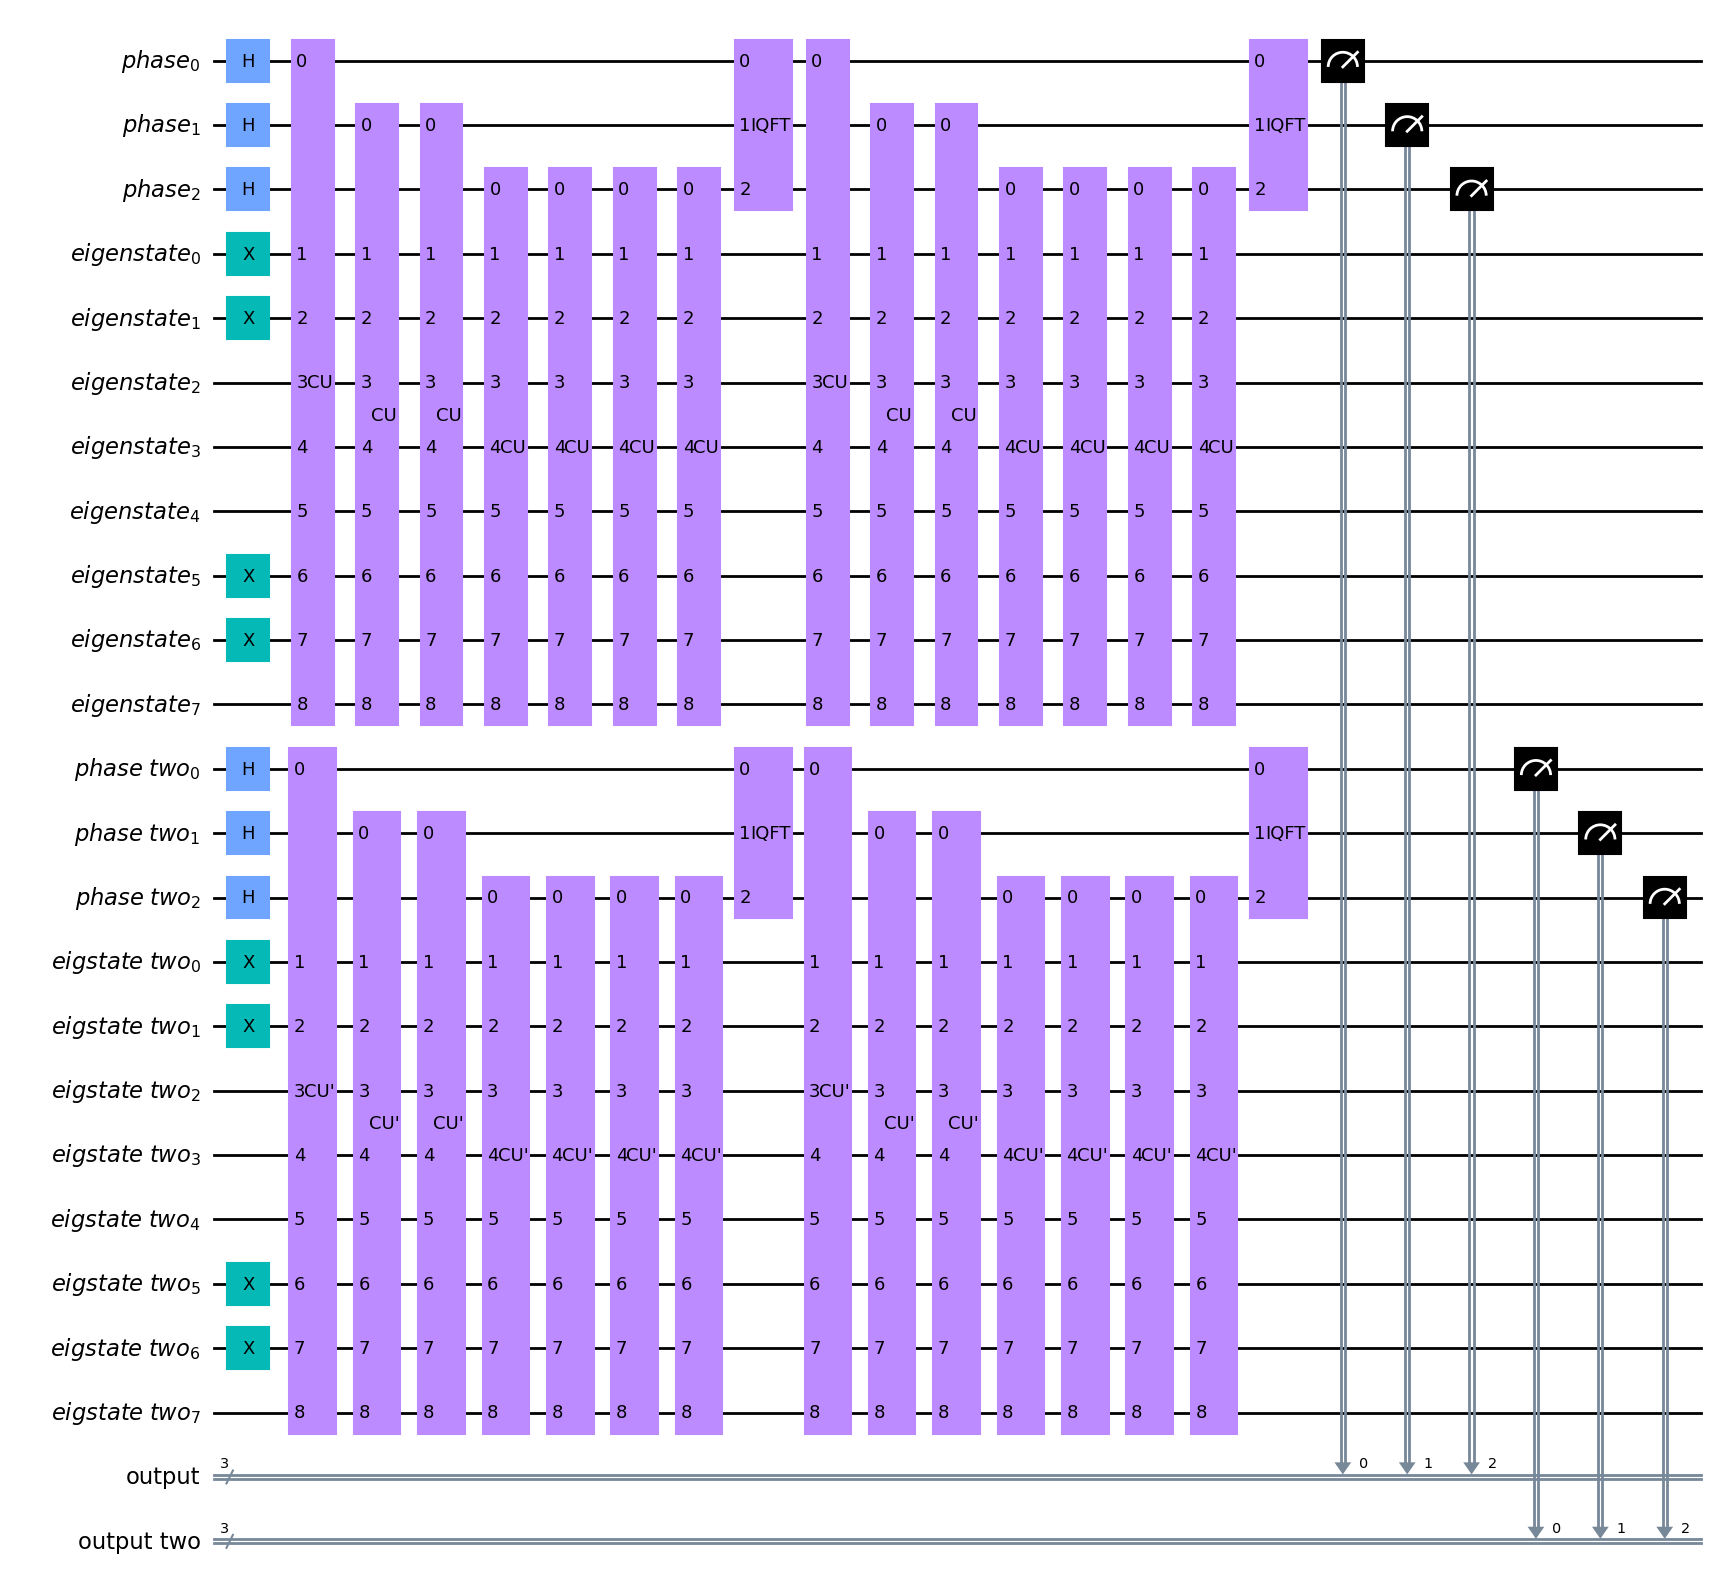

In [16]:
qc.draw(output = 'mpl')

In [17]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

ModuleNotFoundError: No module named 'qiskit.providers.aer'